In [80]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


In [81]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Using TensorFlow backend.

In [82]:
data = pd.read_csv("data_set/application_record.csv", encoding ='utf-8')
record = pd.read_csv("data_set/credit_record.csv", encoding ='utf-8')

In [83]:
plt.rcParams['figure.facecolor'] = 'white'

## Feature Engineering
-  Response Variable

In [84]:
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'})
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

- Generally, users in risk should be in 3%, thus I choose users who overdue for more than 60 days as target risk users. Those samples are marked as '1', else are '0'.

In [85]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='3']='Yes'
record['dep_value'][record['STATUS'] =='4']='Yes'
record['dep_value'][record['STATUS'] =='5']='Yes' 

In [86]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [87]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month,dep_value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-15.0,No,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-14.0,No,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,-2420,1,0,0,0,Managers,2.0,-11.0,Yes,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-23.0,Yes,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-32.0,Yes,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,-655,1,0,0,0,Sales staff,2.0,-9.0,No,0


In [88]:
# Calculate Applicant Age and Years of Working
new_data["APPLICATION_AGE"] = -new_data["DAYS_BIRTH"] // 365
new_data["YEARS_OF_WORKING"] = -new_data["DAYS_EMPLOYED"] // 365

In [90]:
# Drop rows where either Years_of_Working is negative
new_data = new_data[
    (new_data['YEARS_OF_WORKING'] >= 0)
    ]

In [91]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month,dep_value,target,APPLICATION_AGE,YEARS_OF_WORKING
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,NaN,2.0,-15.0,No,0,32,12
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,NaN,2.0,-14.0,No,0,32,12
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Security staff,2.0,-29.0,No,0,58,3
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,-4.0,No,0,52,8
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,-26.0,No,0,52,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Managers,2.0,-11.0,Yes,1,47,6
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,0,1,1,Medicine staff,2.0,-23.0,Yes,1,33,3
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,0,1,1,Medicine staff,2.0,-32.0,Yes,1,33,3
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Sales staff,2.0,-9.0,No,0,49,1


In [92]:
new_data = new_data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1)

In [93]:
new_data = new_data.drop(['dep_value'], axis=1)

In [95]:
new_data = new_data.drop(['begin_month'], axis=1)

In [96]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target,APPLICATION_AGE,YEARS_OF_WORKING
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0,32,12
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0,32,12
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,58,3
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Managers,2.0,1,47,6
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,1,33,3
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,1,33,3
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Sales staff,2.0,0,49,1


## normalization 
- AMT_INCOME_TOTAL 

In [97]:
# For Z-score normalization
scaler_zscore = StandardScaler()
zscore_cols = ['AMT_INCOME_TOTAL']
# Create new column names for normalized features
zscore_cols_scaled = [col + '_zscore' for col in zscore_cols]
# Transform and assign to new columns
new_data[zscore_cols_scaled] = scaler_zscore.fit_transform(new_data[zscore_cols])

In [98]:
new_data = new_data.drop(['AMT_INCOME_TOTAL'], axis=1)

In [99]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target,APPLICATION_AGE,YEARS_OF_WORKING,AMT_INCOME_TOTAL_zscore
0,5008804,M,Y,Y,0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0,32,12,2.230993
1,5008805,M,Y,Y,0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0,32,12,2.230993
2,5008806,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,58,3,-0.783777
3,5008808,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8,0.723608
4,5008809,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8,0.723608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Managers,2.0,1,47,6,1.154290
36453,5149834,F,N,Y,0,Commercial associate,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,1,33,3,-0.353096
36454,5149838,F,N,Y,0,Pensioner,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,1,33,3,-0.353096
36455,5150049,F,N,Y,0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Sales staff,2.0,0,49,1,0.852813


In [100]:
# Apply filtering conditions
filtered_application_df = new_data[
    (new_data["APPLICATION_AGE"] >= 21) &
    new_data["CODE_GENDER"].notnull() &
    new_data["FLAG_OWN_CAR"].notnull() &
    new_data["FLAG_OWN_REALTY"].notnull() &
    new_data["CNT_CHILDREN"].notnull() &
    new_data["NAME_INCOME_TYPE"].notnull() &
    new_data["NAME_EDUCATION_TYPE"].notnull() &
    new_data["NAME_FAMILY_STATUS"].notnull() &
    new_data["NAME_HOUSING_TYPE"].notnull()
    ]

In [111]:
filtered_application_df['FLAG_MOBIL'].value_counts()

FLAG_MOBIL
1    30321
Name: count, dtype: int64

In [114]:
filtered_application_df['target'] = new_data['target'].astype(int)

In [117]:
filtered_application_df['target'].value_counts()

target
0    30083
1      238
Name: count, dtype: int64

In [120]:
filtered_application_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target,APPLICATION_AGE,YEARS_OF_WORKING,AMT_INCOME_TOTAL_zscore
0,5008804,M,Y,Y,0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0,32,12,2.230993
1,5008805,M,Y,Y,0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0,32,12,2.230993
2,5008806,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,58,3,-0.783777
3,5008808,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8,0.723608
4,5008809,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8,0.723608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Managers,2.0,1,47,6,1.154290
36453,5149834,F,N,Y,0,Commercial associate,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,1,33,3,-0.353096
36454,5149838,F,N,Y,0,Pensioner,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,1,33,3,-0.353096
36455,5150049,F,N,Y,0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Sales staff,2.0,0,49,1,0.852813


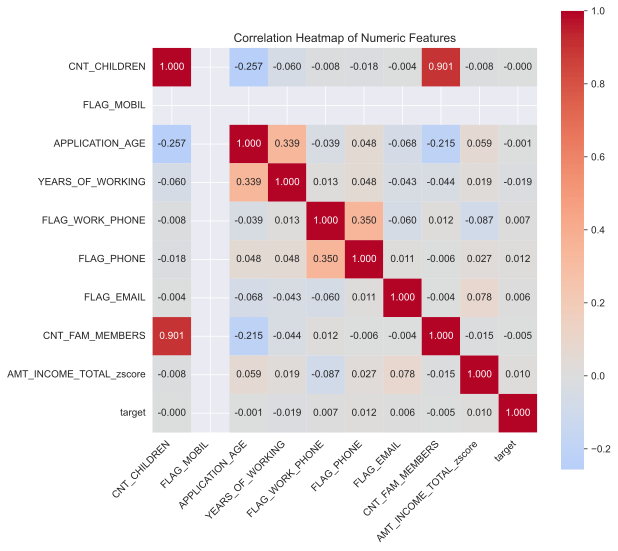

In [115]:
numeric_cols = ['CNT_CHILDREN', 'FLAG_MOBIL', 'APPLICATION_AGE', 'YEARS_OF_WORKING',
                'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
                'CNT_FAM_MEMBERS','AMT_INCOME_TOTAL_zscore','target']

# Calculate correlation matrix
correlation_matrix = filtered_application_df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(9, 8))
sns.heatmap(correlation_matrix,
            annot=True,  # Show numbers
            cmap='coolwarm',  # Red/Blue color scheme
            center=0,  # Center the colorbar at 0
            fmt='.3f',  # 2 decimal places
            square=True)  # Make cells square

plt.title('Correlation Heatmap of Numeric Features')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [118]:
new_data = new_data.drop(['FLAG_MOBIL'], axis=1)

KeyError: "['FLAG_MOBIL'] not found in axis"

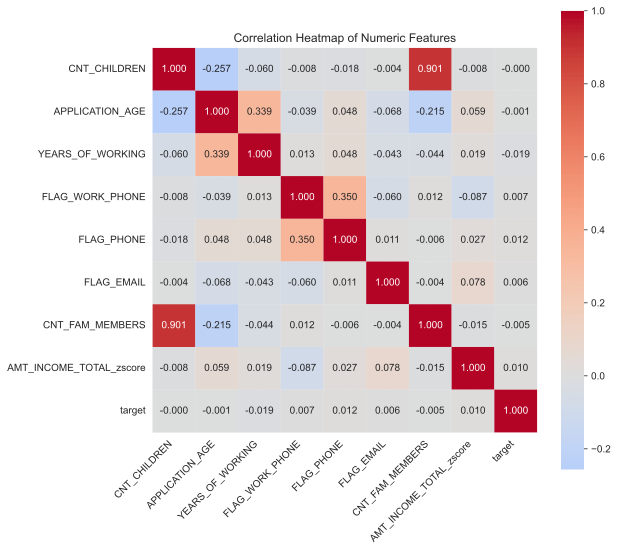

In [119]:
numeric_cols = ['CNT_CHILDREN', 'APPLICATION_AGE', 'YEARS_OF_WORKING',
                'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
                'CNT_FAM_MEMBERS','AMT_INCOME_TOTAL_zscore','target']

# Calculate correlation matrix
correlation_matrix = filtered_application_df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(9, 8))
sns.heatmap(correlation_matrix,
            annot=True,  # Show numbers
            cmap='coolwarm',  # Red/Blue color scheme
            center=0,  # Center the colorbar at 0
            fmt='.3f',  # 2 decimal places
            square=True)  # Make cells square

plt.title('Correlation Heatmap of Numeric Features')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Features

In [121]:
# drop null and NAN
filtered_application_df.dropna()
filtered_application_df = filtered_application_df.mask(filtered_application_df == 'NULL').dropna()

In [122]:
filtered_application_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target,APPLICATION_AGE,YEARS_OF_WORKING,AMT_INCOME_TOTAL_zscore
2,5008806,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,58,3,-0.783777
3,5008808,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8,0.723608
4,5008809,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8,0.723608
5,5008810,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8,0.723608
6,5008811,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8,0.723608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Managers,2.0,1,47,6,1.154290
36453,5149834,F,N,Y,0,Commercial associate,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,1,33,3,-0.353096
36454,5149838,F,N,Y,0,Pensioner,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,1,33,3,-0.353096
36455,5150049,F,N,Y,0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Sales staff,2.0,0,49,1,0.852813


In [ ]:
ivtable=pd.DataFrame(filtered_application_df.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

- Define calc_iv function to calculate -> https://www.kaggle.com/code/puremath86/iv-woe-starter-for-python Information Value and WOE Value

# Binary Features

In [ ]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [ ]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [ ]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut

    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- Gender

In [ ]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

- Having a car or not

In [ ]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

- Having house reality or not¶

In [ ]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

- Having a phone or not

In [ ]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

- Having an email or not

In [ ]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

- Having a Work Phone or not

In [ ]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

## Continuous Variables
- Children Numbers

In [ ]:
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

In [ ]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

In [ ]:
new_data = convert_dummy(new_data,'ChldNo')

- Annual Income

In [ ]:
new_data['inc']=new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000
print(new_data['inc'].value_counts(bins=10,sort=False))
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [ ]:
new_data

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=new_data['inc'], color="green")
plt.xlabel("Annual Income")
plt.title("Distribution of Annual Income")
plt.show()

In [ ]:
# print(new_data['inc'].dtype)
new_data['inc'] = pd.to_numeric(new_data['inc'], errors='coerce')
#- แปลง new_data['inc'] เป็น num ใน notebook ไม่มี

In [ ]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

In [ ]:
new_data = convert_dummy(new_data,'gp_inc')

## Age
- Bucketing Continuous Variables

In [ ]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

In [ ]:
new_data = convert_dummy(new_data,'gp_Age')

## Working Years 
- Equal-length Bucketing

In [ ]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean
print(new_data['worktm'].value_counts(bins=20,normalize=True,sort=False))
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

In [ ]:
new_data = convert_dummy(new_data,'gp_worktm')

- Family Size

In [ ]:
new_data['famsize'].value_counts(sort=False)

In [ ]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

In [ ]:
new_data = convert_dummy(new_data,'famsizegp')

### Categorical Features
- Income Type

In [ ]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

In [ ]:
new_data = convert_dummy(new_data,'inctp')

## Occupation Type

In [ ]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head() 

In [ ]:
new_data = convert_dummy(new_data,'occyp')

## House Type

In [ ]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

In [ ]:
new_data = convert_dummy(new_data,'houtp')

## Education

In [ ]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

In [ ]:
new_data = convert_dummy(new_data,'edutp')

## Marriage Condition

In [ ]:
new_data['famtp'].value_counts(normalize=True,sort=False)

In [ ]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

In [ ]:
new_data = convert_dummy(new_data,'famtp')

## IV、WOE：Concept and Application

Weight of Evidence(WoE):  

$$wo{e_i} = \ln {{{P_{yi}}} \over {{P_{ni}}}} = \ln {{{y_i}/{y_s}} \over {{n_i}/{n_s}}}$$
$wo{e_i}$ is the I category's WOE value. ${{P_{yi}}}$ is the proportion of the positive samples in this category to all positive samples.   ${{P_{ni}}}$ is the ratio of negative samples (${{n_i}}$) in this class to all negative samples (${{n_s}}$).

Information Value (IV):  
$$I{V_i} = ({P_{yi}} - {P_{ni}}) \times wo{e_i}$$  
The IV values of the various types are the difference between the conditional positive rate and the conditional negative rate multiplied by the WOE value of the variable. The total IV value of the variable can be understood as the weighted sum of the conditional positive rate and the conditional negative rate difference:
$$IV = \sum\limits_i^n {I{V_i}} $$  

The IV value measures the variable's ability to predict.


Relationship between IV value and predictive power

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Almost no predictive power | 
|0.02~0.1 |weak predictive power|
|0.1~0.3|Moderate predictive power|
|0.3~0.5|Strong predictive power|
|>0.5|Predictive power is too strong, need to check variables| 

In [ ]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

# Algorithms
- Split Dataset

In [ ]:
new_data

In [ ]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
              'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
              'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk',
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
              'houtp_Co-op apartment', 'houtp_Municipal apartment',
              'houtp_Office apartment', 'houtp_Rented apartment',
              'houtp_With parents','edutp_Higher education',
              'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
              'famtp_Separated','famtp_Single / not married','famtp_Widow']]

+ Using Synthetic Minority Over-Sampling Technique(`SMOTE`) to overcome sample imbalance problem.

In [ ]:
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

+ After over sampling, the number between 1 and 0 is balanced. It can be seen from the confusion matrix.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance,
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

In [ ]:
print(X_train)

## Logistic Regression   

$$\log ({p \over {1 - p}}) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white')
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True,
                      title='Normalized Confusion Matrix: Logistic Regression')


## Decision Tree

In [ ]:
model = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: CART')

## Random Forest   



<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://d1rwhvwstyk9gu.cloudfront.net/2019/03/Random-Forest-Algorithm.jpg">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">Random Forest</div>
</center>

In [ ]:
model = RandomForestClassifier(n_estimators=250,
                               max_depth=12,
                               min_samples_leaf=16
                               )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: Ramdom Forests')

## SVM


<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://i.loli.net/2019/11/13/fryWG5al7OPHDiA.gif">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">Support Vector Machine</div>
</center>

In [ ]:
model = svm.SVC(C = 0.8,
                kernel='linear')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: SVM')

## Showing important features:

In [ ]:
# def plot_importance(classifier, x_train, point_size = 25):
#     '''plot feature importance'''
#     values = sorted(zip(x_train.columns, classifier.feature_importances_), key = lambda x: x[1] * -1)
#     imp = pd.DataFrame(values,columns = ["Name", "Score"])
#     imp.sort_values(by = 'Score',inplace = True)
#     sns.scatterplot(x = 'Score',y='Name', linewidth = 0,
#                     data = imp,s = point_size, color='red').set(
#         xlabel='importance',
#         ylabel='features')
# 
# plot_importance(model, X_train,20)   